## Importing Libraries

In [1]:
import numpy as np
import scipy
from scipy import io as sio
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csgraph
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DenseDataLoader

import networkx as nx
from networkx import smallworld
import matplotlib.patches as mpatches


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [3]:
device

device(type='cuda')

## New Data

In [4]:
# add_data = sio.loadmat('../data/additional/Individual_Connectomes.mat')

In [5]:
# atlas = [0]#np.arange(5)
# subjects = np.arange(70)
# SC_data, FC_data = [], []
# for atlas_ind in atlas:
#     for subj_ind in subjects:
#         SC_data.append(add_data['connMatrices'][0][0][0][atlas_ind][0][:,:,subj_ind])
#         FC_data.append(add_data['connMatrices'][0][0][1][atlas_ind][0][:,:,subj_ind])
#             # plt.imshow(add_data['connMatrices'][0][0][conn_ind][atlas_ind][0][:,:,subj_ind])
# SC_data = np.array(SC_data)
# FC_data = np.array(FC_data)

In [6]:
# SC_data.shape,FC_data.shape

## Data

In [7]:
fc_sc_set = sio.loadmat('./../data/fc_and_sc_sets.mat')
scs_desikan = sio.loadmat('./../data/scs_desikan.mat')
IDs = scs_desikan['subject_list']
correlations_desikan_old = sio.loadmat('./../data/correlations_desikan_old.mat')

In [8]:
len(fc_sc_set['exist_any_fc_and_sc'])
fc_sc_set.keys(),
scs_desikan.keys(),correlations_desikan_old.keys()
len(scs_desikan['subject_list']),len(correlations_desikan_old['subject_list'])+len(correlations_desikan_old['missing_data_rel2scs_patient_ids'])

(1065, 1065)

In [9]:
### sFC ###
# tfc_data = np.load('./../data/sFC_EMOTION_RL/emotion_tfmri_correlation.npy',allow_pickle=True).item()
### stat map fc ###
# tfc_data = np.load('/home/chirag/nas/HCP/task/neurovault_try4/smFC_dict.npy',allow_pickle=True).item()

In [11]:
def align_fc2sc(matrix):
    top_left = matrix[:-19, :-19]
    top_right = matrix[:-19, -19:]
    bottom_left = matrix[-19:, :-19]
    bottom_right = matrix[-19:, -19:]
    
    # Rearrange the parts
    new_matrix = np.block([
        [bottom_right, bottom_left],
        [top_right, top_left]
    ])
    return new_matrix

def rm_subctl(matrix):
    new_matrix = matrix[19:, 19:]
    return new_matrix

(1058, 87, 87) (1058, 87, 87)
(1058, 87, 87) (1058, 87, 87) (1058, 87, 87)


(-0.5, 86.5, 86.5, -0.5)

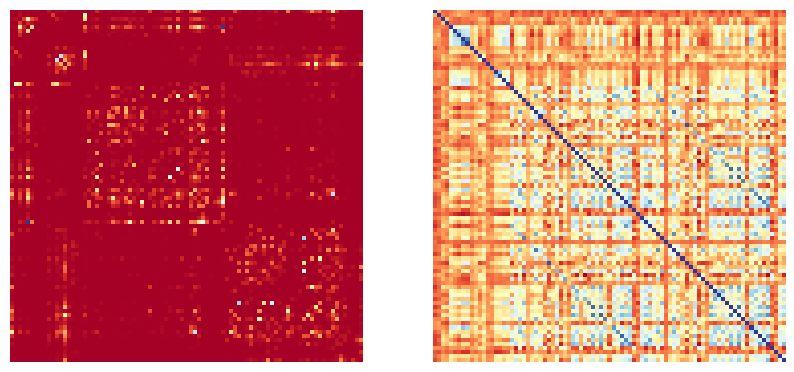

In [13]:
subject_ids = []
SC_data,FC_data=[],[]
for i,id in enumerate(IDs):
    if id in scs_desikan['subject_list'] and id in correlations_desikan_old['subject_list']:#tfc_data['subject_list']:
        subject_ids.append(id)
        sc_pos = np.where(scs_desikan['subject_list']==id)[0][0]
        fc_pos = np.where(correlations_desikan_old['subject_list']==id)[0][0]
        # fc_pos = np.where(tfc_data['subject_list']==id)[0][0]
        SC_temp = scs_desikan['scs'][:,:,sc_pos].astype(np.float32)
        FC_temp = correlations_desikan_old['fcs'][:,:,fc_pos].astype(np.float32)
        # FC_temp = tfc_data['fc_matrix'][fc_pos].astype(np.float32)
        SC_temp = (SC_temp + SC_temp.transpose()) / 2
        SC_data.append(SC_temp)
        FC_data.append(align_fc2sc(FC_temp))


SC_data = np.array(SC_data)
FC_data = np.array(FC_data)

print(SC_data.shape,FC_data.shape)

subj = FC_data.shape[0]
rows = FC_data.shape[1]
cols = FC_data.shape[2]

#MinMax SC-Matrix Normalization
SC_data_norm = np.zeros([subj,rows,cols])

for i in np.arange(SC_data.shape[0]):
    scaler_sc = MinMaxScaler(feature_range=(0, 1))
    scaler_sc.fit(SC_data[i].flatten().reshape(-1,1))
    temp = scaler_sc.transform(SC_data[i].flatten().reshape(-1,1))
    SC_data_norm[i] = np.reshape(temp,(SC_data.shape[1],SC_data.shape[2]))


degree_sc =  np.zeros([subj,rows])
L_sc = np.zeros([subj,rows,cols])

for i in np.arange(subj):
    for j in np.arange(rows):
        degree_sc[i][j] = np.sum(SC_data_norm[i][j])
    # L_sc[i] = np.diag(degree_sc[i]) - SC_data_norm[i]
    L_sc[i] = csgraph.laplacian(SC_data_norm[i])


#eigendecomposition
Evec = np.zeros([subj,rows,cols])
Eval = np.zeros([subj,rows])
for i in np.arange(subj):
    w, u = np.linalg.eigh(L_sc[i])
    Evec[i] = u
    Eval[i] = w

k=87###### K VALUE SET HERE ######
Evec_k = Evec[:,:,:k]
Eval_k = Eval[:,:k]

print(SC_data.shape,FC_data.shape,L_sc.shape)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(SC_data_norm[0],cmap='RdYlBu')
plt.axis('off')
# plt.colorbar()
plt.subplot(122)
plt.imshow(FC_data[0],cmap='RdYlBu')
plt.axis('off')
# plt.colorbar()
# plt.subplot(143)
# plt.imshow(L_sc[0],cmap='RdYlBu')
# plt.axis('off')
# # plt.colorbar()
# plt.subplot(144)
# plt.imshow(Evec[0],cmap='RdYlBu')
# # plt.colorbar()

In [14]:
# plt.figure(figsize=(20,10))
# for i in range(20):
#     plt.subplot(4,5,i+1)
#     plt.imshow(FC_data[i],cmap='RdYlBu')
#     plt.axis('off')

In [15]:
# plt.figure(figsize=(20,10))
# for i in range(20):
#     plt.subplot(4,5,i+1)
#     plt.imshow(SC_data[i],cmap='RdYlBu')
#     plt.axis('off')

In [16]:
# G = nx.from_numpy_array(SC_data_norm[0])
# smallworld.sigma(G, niter=1, nrand=1)

## Scale Selection

In [17]:
def getS_minmax(lambda_2,lambda_N,eta=0.85,gamma=0.95):
    norm=np.sqrt(lambda_2*lambda_N)
    s_max = -np.log(eta)/norm
    s_min = -np.log(gamma)/norm
    return s_min,s_max

s_ls = np.zeros([len(Eval_k),2])
for i in range(len(Eval_k)):
    lambda_2,lambda_N =  Eval_k[i][1],Eval_k[i][-1]
    s_min,s_max = getS_minmax(lambda_2,lambda_N)
    s_ls[i] = [s_min,s_max]
    

/tmp/ipykernel_898968/3793679240.py:2: RuntimeWarning: invalid value encountered in sqrt
  norm=np.sqrt(lambda_2*lambda_N)


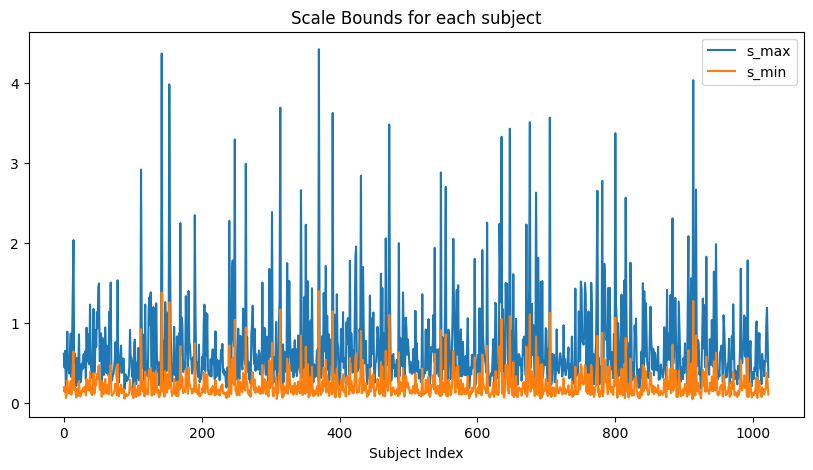

In [18]:
eta,gamma=0.85,0.95
l1_x_lN = Eval_k[:,1]*Eval_k[:,-1]
invalid_loc = np.where(l1_x_lN<0)
l1_x_lN=np.delete(l1_x_lN,invalid_loc)
root_l1_x_lN = np.sqrt(l1_x_lN)
s_min,s_max = -np.log(gamma)/root_l1_x_lN ,-np.log(eta)/root_l1_x_lN
plt.figure(figsize=(10,5))
plt.plot(s_max[s_min<1e4],label='s_max')
plt.plot(s_min[s_min<1e4],label='s_min')
plt.xlabel('Subject Index')
plt.title('Scale Bounds for each subject')
plt.legend()
plt.show()

In [19]:
np.max(s_max[s_min<1e4]),np.min(s_min[s_min<1e4])

(4.417309181019828, 0.04442881223514183)

In [20]:
# eta,gamma=0.85,0.95
# root_s_prod = np.sqrt(np.abs(Eval_k[:,1]*Eval_k[:,-1]))
# s_max = -np.log(eta)/root_s_prod
# s_min = -np.log(gamma)/root_s_prod
# np.min(s_min),np.min(s_max)
# plt.subplot(211)
# plt.plot(s_min[s_min<1e2],'r')
# plt.subplot(212)
# plt.plot(s_max[s_min<1e2],'b')
# plt.show()

In [21]:
# #save the SC and FC matrices as dict with imdex as the key
# data_dict = {}
# for i in np.arange(subj):
#     data_dict[i] = (SC_data_norm[i],FC_data[i])

# #save the data_dict as a .npy file
# np.save('./../data/data_dict.npy',data_dict)

## Dataloader

In [22]:
# #save SC_data_norm and FC_data as .mat files
# sio.savemat('./../data/SC_data.mat',{'SC_data_norm':SC_data_norm})
# sio.savemat('./../data/FC_data.mat',{'FC_data':FC_data})

In [23]:
SC = torch.from_numpy(SC_data_norm.astype(np.float32))
FC = torch.from_numpy(FC_data.astype(np.float32))
L = torch.from_numpy(L_sc.astype(np.float32))
EVAL = torch.from_numpy(Eval_k.astype(np.float32))
EVEC = torch.from_numpy(Evec_k.astype(np.float32))

def create_data_list(SC,FC,L,EVAL,EVEC):
    data_list = []
    for i in range(SC.shape[0]):
        x = SC[i]
        #consider only thode edges with correlation > 0.5
        edge_index = torch.from_numpy(np.indices(x.shape).reshape(2,-1))
        y = FC[i]
        data = Data(x=x, y=y, edge_index=edge_index,edge_weight=x.flatten(),laplacian=L[i],eigenvalues=EVAL[i],eigenvectors=EVEC[i])
        data_list.append(data)
    return data_list

conn_mat_list = create_data_list(SC,FC,L,EVAL,EVEC)
pygBatch = Batch.from_data_list(conn_mat_list).to(device)

print("Number of nodes in each brain graph:",pygBatch.num_nodes)
print("Number of SC-FC pairs:",pygBatch.num_graphs)

#divide the pygBatch randomly into train, val and test
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

train_ratio = 0.5
val_ratio = 0.05
test_ratio = 1-train_ratio-val_ratio

#randomly shuffle the indices and splits should not overlap
def get_data_loader(
        pygBatch, 
        BATCH_SIZE,
        train_ratio = 0.8,
        val_ratio = 0.1
        ):

    indices = np.random.permutation(pygBatch.num_graphs)

    train_split = int(train_ratio*pygBatch.num_graphs)
    val_split = int((train_ratio+val_ratio)*pygBatch.num_graphs)

    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]

    train_batch = pygBatch.index_select(train_indices)
    val_batch = pygBatch.index_select(val_indices)
    test_batch = pygBatch.index_select(test_indices)

    #perturb test batch

    train_loader = DenseDataLoader(train_batch, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DenseDataLoader(val_batch, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DenseDataLoader(test_batch, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader,train_indices,val_indices,test_indices


train_loader, val_loader, test_loader,train_indices,val_indices,test_indices = get_data_loader(pygBatch, train_ratio=train_ratio,val_ratio=val_ratio,BATCH_SIZE=16)
print(len(train_loader), len(val_loader), len(test_loader))

Number of nodes in each brain graph: 92046
Number of SC-FC pairs: 1058
34 4 30


In [56]:
SC_sub, FC_sub, L_sub, EVAL_sub, EVEC_sub = SC[0].numpy(), FC[0].numpy(), L[0].numpy(), EVAL[0].numpy(), EVEC[0].numpy()
scales_path = '../results/scales_min2.txt'
scales_ls = np.loadtxt(scales_path,delimiter=',')
scales_avg = np.mean(scales_ls,axis=0)
diff_coef = -EVAL_sub*scales_avg
heat_kern = EVEC_sub @ np.diag(np.exp(diff_coef)) @ EVEC_sub.T
wavelet = heat_kern[83]
# plt.plot(wavelet)
# plt.figure(figsize=(10,5))
# plt.imshow(heat_kern,cmap='RdYlBu')
# plt.axis('off')
# plt.title('Heat Kernel')
# save wavelet and sc_sub
np.save('../results/wavelet.npy',wavelet,allow_pickle=True)
np.save('../results/sc_sub.npy',SC_sub,allow_pickle=True)

## Heat Kernel

In [77]:
def assymetricKernel_batch4(eval,evec,t_arr): ## Verified using loops
    try:
        N,k = evec.shape
        evec = evec.unsqueeze(0)
        eval = eval.unsqueeze(0)
    except:
        B,N,k = evec.shape
    # print(eval.shape,evec.shape,t_arr.shape)
    #add new dimension and stack horixontally k times
    b = torch.stack([t_arr]*(k-1),1).unsqueeze(0)
    c = torch.stack([eval[:,1:]]*N,1)
    evec = evec[:,:,1:]
    # print(b.shape,c.shape)
    expa = torch.exp(-b*c)
    bnkk = torch.diag_embed(expa)
    # print(bnkk.shape,evec.shape)
    pre_f = evec.unsqueeze(-3) @ bnkk @ evec.unsqueeze(-3).transpose(-1,-2)
    
    final = torch.diagonal(pre_f,dim1=-2).transpose(-1,-2)
    return final

## Diffusion

In [78]:
def operateOnSC(kern,sc):
    # kern(B,N,N) sc(B,N,N)
    return torch.matmul(kern,sc)

## Learn Time

In [79]:
class LearnedTimeAssymmetricDiffusion(nn.Module):
    def __init__(self):
        super(LearnedTimeAssymmetricDiffusion, self).__init__()
        self.diffusion_time = nn.Parameter(torch.Tensor(87))  # (C)
        nn.init.constant_(self.diffusion_time, 0.0)
        #uniform intialization (0,10)
        # nn.init.uniform_(self.diffusion_time, a=1e-8, b=10.0)
        #gaussian initialization (0,10)
        # nn.init.normal_(self.diffusion_time, mean=5.0, std=2.0)

    def assymetricKernel_batch4(self,eval,evec,t_arr): ## Verified using loops
        '''
        eval(B,k)
        evec(B,N,k)
        t_arr(N)
        '''
        try:
            N,k = evec.shape
            evec = evec.unsqueeze(0)
            eval = eval.unsqueeze(0)
        except:
            B,N,k = evec.shape
        # print(eval.shape,evec.shape,t_arr.shape)
        # add new dimension and stack horixontally k times
        b = torch.stack([t_arr]*k,1).unsqueeze(0)
        c = torch.stack([eval[:,:]]*N,1)
        # evec = evec[:,:,:]
        # print(b.shape,c.shape)
        expa = torch.exp(-b*c)
        bnkk = torch.diag_embed(expa)
        # print(bnkk.shape,evec.shape)
        pre_f = evec.unsqueeze(-3) @ bnkk @ evec.unsqueeze(-3).transpose(-1,-2)
        
        final = torch.diagonal(pre_f,dim1=-2).transpose(-1,-2) #takes the rows of symmetric heat kernel to form rows of the assymetric kernel. Alternatively can take columns and then transpose
        return final
    
    def operateOnSC(self,kern,sc):
        '''
        kern(B,N,N) 
        sc(B,N,N)
        '''
        return torch.matmul(kern,sc)


    def forward(self, x, evals, evecs):
        '''
        x: SC matrix (B,N,N)
        evals: eigenvalues of the laplacian (B,k)
        evecs: eigenvectors of the laplacian (B,N,k)
        '''
        # project times to the positive halfspace
        # (and away from 0 in the incredibly rare chance that they get stuck)
        try:
            N,k = evecs.shape
            x = x.unsqueeze(0)
        except:
            B,N,k = evecs.shape
        with torch.no_grad():
            # self.diffusion_time.data = torch.clamp(self.diffusion_time, max=4.417309181019828,min= 0.04442881223514183)#1e-8)
            self.diffusion_time.data = torch.clamp(self.diffusion_time,min=1e-8)

        #get assymetric kernel
        kernel = self.assymetricKernel_batch4(evals,evecs,self.diffusion_time)
        # print(kernel.shape)
        #operate on SC
        # x_diffuse = self.operateOnSC(kernel,x)
        #concatenate the x and x_diffuse
        # print(x.shape,kernel.shape)
        x_diffuse = torch.cat([x,kernel],dim=2)
        # print(x_diffuse.shape)

        return x_diffuse
    
# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob=None):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.activation1 = nn.LeakyReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         # self.activation2 = nn.LeakyReLU()
#         # self.fc3 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.activation1(x)
#         # if self.dropout is not None:
#         #     x = self.dropout(x)
#         x = self.fc2(x)
#         # x = self.activation2(x)
#         # if self.dropout is not None:
#         #     x = self.dropout(x)
#         # x = self.fc3(x)
#         return x
    
    
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.diffusion = LearnedTimeAssymmetricDiffusion()
#         self.mlp = MLP(87, 87, 87)

#     def forward(self, data):
#         x, evals, evecs = data.x, data.eigenvalues, data.eigenvectors
#         x = self.diffusion(x, evals, evecs)
#         x = self.mlp(x)#.flatten())
#         return x#.view(-1,87,87)

class MiniMLP(nn.Sequential):
    '''
    A simple MLP with configurable hidden layer sizes.
    '''
    def __init__(self, layer_sizes, dropout=False, activation=nn.ReLU, name="miniMLP"):
        super(MiniMLP, self).__init__()

        for i in range(len(layer_sizes) - 1):
            is_last = (i + 2 == len(layer_sizes))

            if dropout and i > 0:
                self.add_module(
                    name + "_mlp_layer_dropout_{:03d}".format(i),
                    nn.Dropout(p=.5)
                )

            # Affine map
            self.add_module(
                name + "_mlp_layer_{:03d}".format(i),
                nn.Linear(
                    layer_sizes[i],
                    layer_sizes[i + 1],
                ),
            )

            # Nonlinearity
            # (but not on the last layer)
            if not is_last:
                self.add_module(
                    name + "_mlp_act_{:03d}".format(i),
                    activation()
                )
    
class Net(nn.Module):
    def __init__(self,input_size=87, hidden_size=64, output_size=87, dropout_prob=None):
        super(Net, self).__init__()
        self.diffusion = LearnedTimeAssymmetricDiffusion()
        # self.mlp = MLP(input_size*2, hidden_size, output_size)
        self.mlp = MiniMLP([input_size*2, output_size], dropout=False, activation=nn.LeakyReLU, name="miniMLP")

    def forward(self, data):
        x, evals, evecs = data.x, data.eigenvalues, data.eigenvectors
        x = self.diffusion(x, evals, evecs)
        x = self.mlp(x)
        return x

## Training

In [80]:
import torchmetrics

def accuracy_fn(pred, label):
    return torchmetrics.functional.mean_absolute_error(pred,label)

def extract_upper(mat):
    n = mat.shape[0]
    indices = torch.triu_indices(n,n)
    return mat[indices[0],indices[1]]

def corr_mat(pred, label):
    pred = extract_upper(pred)
    label = extract_upper(label)
    return torch.corrcoef(torch.stack((pred,label),dim=0)).mean()

def batch_pearson_correlation(x, y):
    x = x.flatten()
    y = y.flatten()
    return np.abs(np.corrcoef(x.cpu().detach().numpy(),y.cpu().detach().numpy()))[1][0]

def mean_square_error(matrix1, matrix2):
    # if matrix1.shape != matrix2.shape:
    #     print(matrix1.shape,matrix2.shape)
    #     raise ValueError("Input matrices must have the same dimensions.")
    squared_diff = (matrix1.cpu().detach().numpy() - matrix2.squeeze(0).cpu().detach().numpy()) ** 2
    mse = np.mean(squared_diff)
    return mse

def frobenius_norm_loss(output, target):
    return torch.norm(output - target, p='fro')

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data, Batch, DenseDataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import time

model = Net().to(device)    #dropout_prob = 0.5
criterion = frobenius_norm_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

def train_step(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(data)
    target = data.y#.view(-1, 1)
    # print(output.shape,target.shape)
    # Compute the loss
    loss = criterion(output, target)

    # Backward pass
    loss.backward()
    optimizer.step()

    return loss.item()

def test_step(model, data, criterion):
    model.eval()

    with torch.no_grad():
        # Forward pass
        output = model(data)
        target = data.y#.view(-1, 1)

        # Compute the loss
        loss = criterion(output, target)

    return loss.item(), output

EPOCHS = 100
trainLossPlt = []
valLossPlt = []
start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for data in train_loader:
        loss = train_step(model, data, optimizer, criterion)
        total_loss += loss
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {average_loss}')
    trainLossPlt.append(average_loss)


    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data in val_loader:
            loss, _ = test_step(model, data, criterion)
            val_loss += loss

    average_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Validation Loss: {average_val_loss}')
    valLossPlt.append(average_val_loss)

    # Adjust learning rate based on validation loss
    scheduler.step(average_val_loss)
end_time = time.time()
# Testing
model.eval()
test_loss = 0
predictions = []

with torch.no_grad():
    for data in test_loader:
        loss, output = test_step(model, data, criterion)
        test_loss += loss
        predictions.append(output)

average_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {average_test_loss}')

Epoch 1/100, Train Loss: 115.23391122529002
Epoch 1/100, Validation Loss: 97.27435779571533
Epoch 2/100, Train Loss: 98.93615930730647
Epoch 2/100, Validation Loss: 86.83991241455078
Epoch 3/100, Train Loss: 91.09539979876894
Epoch 3/100, Validation Loss: 81.38272953033447
Epoch 4/100, Train Loss: 86.48747808283025
Epoch 4/100, Validation Loss: 77.79955291748047
Epoch 5/100, Train Loss: 83.2794478445342
Epoch 5/100, Validation Loss: 75.28145503997803
Epoch 6/100, Train Loss: 81.01053388190992
Epoch 6/100, Validation Loss: 73.48778057098389
Epoch 7/100, Train Loss: 79.39846443407464
Epoch 7/100, Validation Loss: 72.19466304779053
Epoch 8/100, Train Loss: 78.23634696729255
Epoch 8/100, Validation Loss: 71.25098323822021
Epoch 9/100, Train Loss: 77.38362849842419
Epoch 9/100, Validation Loss: 70.55168342590332
Epoch 10/100, Train Loss: 76.74533878673206
Epoch 10/100, Validation Loss: 70.02460193634033
Epoch 11/100, Train Loss: 76.25774834372781
Epoch 11/100, Validation Loss: 69.6205806732

In [82]:
time_taken = end_time - start_time
print(f'Time taken for training: {time_taken} seconds')

Time taken for training: 6.468875169754028 seconds


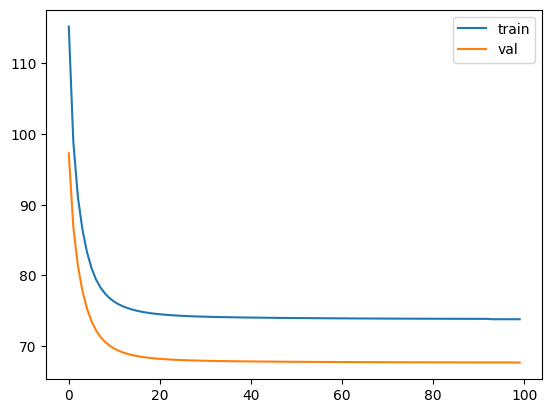

In [83]:
plt.plot(trainLossPlt,label='train')
plt.plot(valLossPlt,label='val')
plt.legend()
plt.show()

In [84]:
# model = models.resnet18()
param_size = 0
buffer_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Size: {:.3f} MB'.format(size_all_mb))

Size: 0.058 MB


In [85]:
param_size

61248

## Analyze MSE and Pearson's Correlation

In [87]:
import pandas as pd
mse_ls = []
pear_ls = []
for ind in range(1033):
    placehold1 = FC[ind]
    placehold2 = model(conn_mat_list[ind].to(device))
    mse_ls.append(mean_square_error(placehold1,placehold2))
    pear_ls.append(batch_pearson_correlation(placehold1,placehold2))
mse_ls = np.array(mse_ls)
pear_ls = np.array(pear_ls)

# print('Train MSE Corr',mse_ls[train_indices].mean(),', Val MSE Corr',mse_ls[val_indices].mean(),', Test MSE Corr',mse_ls[test_indices].mean())
# print('Train Pearson Corr',pear_ls[train_indices].mean(),', Val Pearson Corr',pear_ls[val_indices].mean(),', Test Pearson Corr',pear_ls[test_indices].mean())
# print(pear_ls[train_indices].mean(),pear_ls[val_indices].mean(),pear_ls[test_indices].mean())
# print(mse_ls[train_indices].mean(),mse_ls[val_indices].mean(),mse_ls[test_indices].mean())
# print(pear_ls[train_indices].std(),pear_ls[val_indices].std(),pear_ls[test_indices].std())
# print(mse_ls[train_indices].std(),mse_ls[val_indices].std(),mse_ls[test_indices].std())#create a table using the following:

train_pear = pear_ls[train_indices]
val_pear = pear_ls[val_indices]
test_pear = pear_ls[test_indices]

train_mse = mse_ls[train_indices]
val_mse = mse_ls[val_indices]
test_mse = mse_ls[test_indices]
#calculate the mean and std of the table

#print a table in the for mean +- std
data = {'Train':[f'{train_pear.mean():.4f} +- {train_pear.std():.4f}',f'{train_mse.mean():.4f} +- {train_mse.std():.4f}'],
        'Val':[f'{val_pear.mean():.4f} +- {val_pear.std():.4f}',f'{val_mse.mean():.4f} +- {val_mse.std():.4f}'],
        'Test':[f'{test_pear.mean():.4f} +- {test_pear.std():.4f}',f'{test_mse.mean():.4f} +- {test_mse.std():.4f}']}
df = pd.DataFrame(data,index=['Pearson Correlation','Mean Squared Error'])
df

#print table for mean
data = {'Train PCC':[f'{train_pear.mean():.4f}'],
        'Val PCC':[f'{val_pear.mean():.4f}'],
        'Test PCC':[f'{test_pear.mean():.4f}'],
        'Train MSE':[f'{train_mse.mean():.4f}'],
        'Test MSE':[f'{val_mse.mean():.4f}'],
        'Val MSE':[f'{test_mse.mean():.4f}']}
df = pd.DataFrame(data,index=['Pearson Correlation'])
df

,Train PCC,Val PCC,Test PCC,Train MSE,Test MSE,Val MSE
Pearson Correlation,0.6546,0.6601,0.6469,0.0465,0.0509,0.0476


In [32]:
arr = np.array([ 0.0257 ,
 0.0249 ,
 0.0247 ,
 0.0247 ,
 0.0247 ,
])

findata = {'mean':arr.mean(),'std':arr.std()}
#print in the format mean +- std
print(f'{findata["mean"]:.4f} +- {findata["std"]:.4f}')

0.0249 +- 0.0004


In [33]:
#plot
# plt.figure(figsize=(10,5))

# plt.subplot(3,1,1)
# plt.plot(mse_ls[train_indices])
# plt.title('train')
# plt.subplot(3,1,2)
# plt.plot(mse_ls[val_indices])
# plt.title('val')
# plt.subplot(3,1,3)
# plt.plot(mse_ls[test_indices])
# plt.title('test')

# plt.suptitle('Mean Square Error (Lower Better)')

# plt.tight_layout()
# plt.show()   

#plot
# plt.figure(figsize=(10,5))

# plt.subplot(3,1,1)
# plt.plot(pear_ls[train_indices])
# plt.title('train')
# plt.subplot(3,1,2)
# plt.plot(pear_ls[val_indices])
# plt.title('val')
# plt.subplot(3,1,3)
# plt.plot(pear_ls[test_indices])
# plt.title('test')

# plt.suptitle('Pearson Correlation (Larger better)')

# plt.tight_layout()
# plt.show()

## Analyze time parameters

tensor([1.0000e-08, 2.7126e-02, 6.2716e-04, 1.0000e-08, 1.3272e-02, 1.5356e-03,
        6.5176e-02, 1.4892e-01, 1.0000e-08, 1.3541e-03, 1.4166e-02, 2.1874e-02,
        2.8402e-02, 7.7173e-05, 5.0123e-03, 4.0229e-03, 1.0000e-08, 1.0000e-08,
        3.0699e-04, 2.2718e-02, 1.0000e-08, 3.5060e-02, 2.2667e-02, 2.9055e-04,
        3.0121e-04, 3.9706e-02, 2.4517e-04, 8.9718e-03, 3.1758e-04, 1.5355e-04,
        3.4368e-02, 1.0000e-08, 7.1364e-06, 6.0027e-04, 4.0122e-05, 6.1166e-02,
        2.4129e-02, 7.7157e-02, 1.6749e-01, 1.0305e-03, 2.9566e-02, 2.4889e-02,
        2.0746e-02, 3.3367e-02, 4.1244e-04, 2.3407e-02, 1.1563e-03, 6.7516e-04,
        1.1620e-03, 2.7102e-01, 4.5895e-04, 7.8295e-02, 1.9385e-02, 9.4741e-02,
        1.0000e-08, 5.2546e-03, 2.5301e-03, 5.7846e-02, 1.2258e-02, 4.2336e-02,
        8.9281e-02, 2.6531e-02, 1.0000e-08, 2.0039e-02, 5.7016e-04, 9.7694e-03,
        4.9085e-02, 1.6432e-02, 4.4772e-03, 1.1376e-01, 6.2306e-02, 2.7721e-02,
        4.6851e-02, 1.6359e-03, 9.2374e-

(1e-08, 0.27101895)

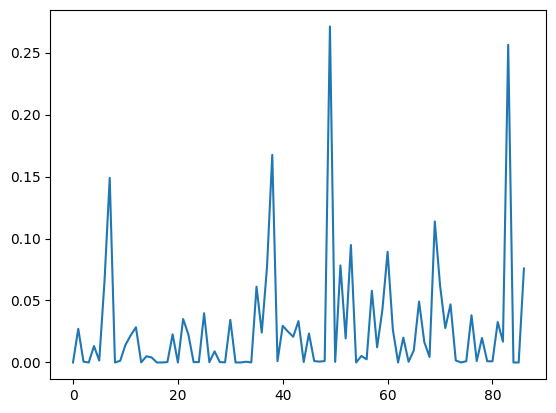

In [34]:
for name, param in model.named_parameters():
    if param.requires_grad:
        diff_arr=param.data
        break
print(diff_arr)
diff_arr = diff_arr.cpu().detach().numpy()
plt.plot(diff_arr)
np.min(diff_arr),np.max(diff_arr)

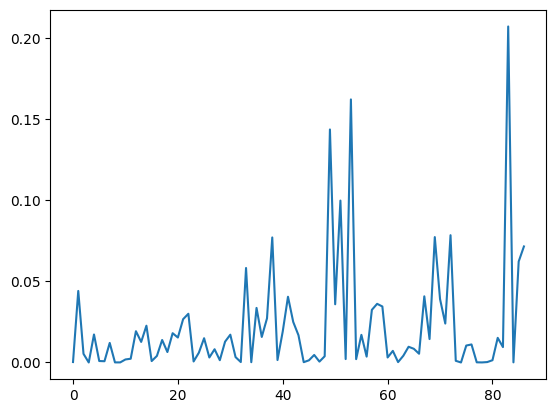

In [35]:
diff_arrs = np.loadtxt('../results/scales_min.txt',delimiter=',')
diff_arr_avg = np.mean(diff_arrs,axis=0)
plt.plot(diff_arr_avg)

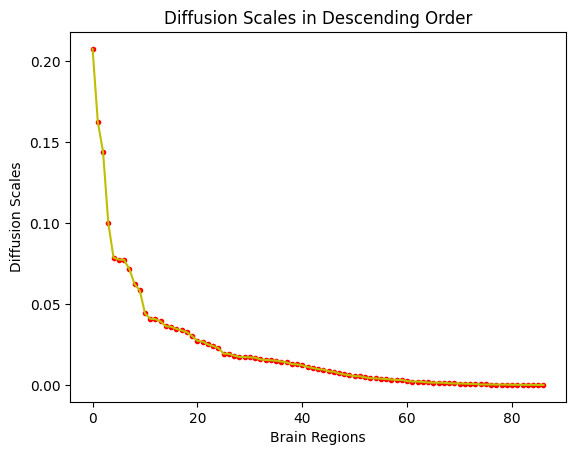

In [36]:
scales_descend = np.sort(diff_arr_avg)[::-1]
plt.figure()
plt.plot(scales_descend,'y')
plt.scatter(np.arange(87),scales_descend,c='r',marker='.')
plt.title('Diffusion Scales in Descending Order')
plt.xlabel('Brain Regions')
plt.ylabel('Diffusion Scales')
plt.savefig('./../figure/scales_descend.pdf',edgecolor='black', dpi=50, facecolor='white', transparent=True, bbox_inches='tight')
plt.show()

In [37]:
# subctxlbl = {
#     0 : 'LH_Lateral-Ventricle',
#     1 : 'LH_Cerebellum-Cortex',
#     2 : 'LH_Thalamus-Proper',
#     3 : 'LH_Caudate',
#     4 : 'LH_Putamen',
#     5 : 'LH_Pallidum',
#     6 : 'LH_Hippocampus',
#     7 : 'LH_Amygdala',
#     8 : 'LH_Accumbens',
#     9 : 'RH_Lateral-Ventricle',
#     10 : 'RH_Cerebellum-Cortex',
#     11 : 'RH_Thalamus-Proper',
#     12 : 'RH_Caudate',
#     13 : 'RH_Putamen',
#     14 : 'RH_Pallidum',
#     15 : 'RH_Hippocampus',
#     16 : 'RH_Amygdala',
#     17 : 'RH_Accumbens',
#     18 : '_Brain-Stem'
#     }
# ctx_lh_lbl = {
#     19  :  'ctx-lh-bankssts',
#     20  :  'ctx-lh-caudalanteriorcingulate',
#     21  :  'ctx-lh-caudalmiddlefrontal',
#     22  :  'ctx-lh-cuneus',
#     23  :  'ctx-lh-entorhinal',
#     24  :  'ctx-lh-fusiform',
#     25  :  'ctx-lh-inferiorparietal',
#     26  :  'ctx-lh-inferiortemporal',
#     27  :  'ctx-lh-isthmuscingulate',
#     28  :  'ctx-lh-lateraloccipital',
#     29  :  'ctx-lh-lateralorbitofrontal',
#     30  :  'ctx-lh-lingual',
#     31  :  'ctx-lh-medialorbitofrontal',
#     32  :  'ctx-lh-middletemporal',
#     33  :  'ctx-lh-parahippocampal',
#     34  :  'ctx-lh-paracentral',
#     35  :  'ctx-lh-parsopercularis',
#     36  :  'ctx-lh-parsorbitalis',
#     37  :  'ctx-lh-parstriangularis',
#     38  :  'ctx-lh-pericalcarine',
#     39  :  'ctx-lh-postcentral',
#     40  :  'ctx-lh-posteriorcingulate',
#     41  :  'ctx-lh-precentral',
#     42  :  'ctx-lh-precuneus',
#     43  :  'ctx-lh-rostralanteriorcingulate',
#     44  :  'ctx-lh-rostralmiddlefrontal',
#     45  :  'ctx-lh-superiorfrontal',
#     46  :  'ctx-lh-superiorparietal',
#     47  :  'ctx-lh-superiortemporal',
#     48  :  'ctx-lh-supramarginal',
#     49  :  'ctx-lh-frontalpole',
#     50  :  'ctx-lh-temporalpole',
#     51  :  'ctx-lh-transversetemporal',
#     52  :  'ctx-lh-insula'
# }
# ctx_rh_lbl = {
#     53  :  'ctx-rh-bankssts',
#     54  :  'ctx-rh-caudalanteriorcingulate',
#     55  :  'ctx-rh-caudalmiddlefrontal',
#     56  :  'ctx-rh-cuneus',
#     57  :  'ctx-rh-entorhinal',
#     58  :  'ctx-rh-fusiform',
#     59  :  'ctx-rh-inferiorparietal',
#     60  :  'ctx-rh-inferiortemporal',
#     61  :  'ctx-rh-isthmuscingulate',
#     62  :  'ctx-rh-lateraloccipital',
#     63  :  'ctx-rh-lateralorbitofrontal',
#     64  :  'ctx-rh-lingual',
#     65  :  'ctx-rh-medialorbitofrontal',
#     66  :  'ctx-rh-middletemporal',
#     67  :  'ctx-rh-parahippocampal',
#     87  :  'ctx-rh-paracentral',
#     69  :  'ctx-rh-parsopercularis',
#     70  :  'ctx-rh-parsorbitalis',
#     71  :  'ctx-rh-parstriangularis',
#     72  :  'ctx-rh-pericalcarine',
#     73  :  'ctx-rh-postcentral',
#     74  :  'ctx-rh-posteriorcingulate', 
#     75  :  'ctx-rh-precentral',
#     76  :  'ctx-rh-precuneus',
#     77  :  'ctx-rh-rostralanteriorcingulate',
#     78  :  'ctx-rh-rostralmiddlefrontal',
#     79  :  'ctx-rh-superiorfrontal',
#     80  :  'ctx-rh-superiorparietal',
#     81  :  'ctx-rh-superiortemporal',
#     82  :  'ctx-rh-supramarginal',
#     83  :  'ctx-rh-frontalpole',
#     84  :  'ctx-rh-temporalpole',
#     85  :  'ctx-rh-transversetemporal',
#     86  :  'ctx-rh-insula'
#     }
# #combine the dicts
# brain_lbl = {}
# brain_lbl.update(ctx_rh_lbl)
# brain_lbl.update(ctx_lh_lbl)
# brain_lbl.update(subctxlbl)

In [38]:
brain_lbl_ls = ['LH_Lateral-Ventricle','LH_Cerebellum-Cortex','LH_Thalamus-Proper','LH_Caudate','LH_Putamen','LH_Pallidum','LH_Hippocampus','LH_Amygdala','LH_Accumbens','RH_Lateral-Ventricle','RH_Cerebellum-Cortex','RH_Thalamus-Proper','RH_Caudate','RH_Putamen','RH_Pallidum','RH_Hippocampus','RH_Amygdala','RH_Accumbens','_Brain-Stem','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts','ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate', 'ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
len(brain_lbl_ls)

87

In [39]:
######## rois of dmn
# isthmuscingulate = [27,61]
# parahippocampal = [33, 67]
# posteriorcingulate = [40, 74]
# precuneus = [42, 76]
# rostralanteriorcingulate = [43,77]

# # all_loc= isthmuscingulate + posteriorcingulate + precuneus + rostralanteriorcingulate + parahippocampal
# all_loc = np.arange(87)
# print(all_loc)

# isthmuscingulate_t = []
# posteriorcingulate_t = []
# precuneus_t = []
# rostralanteriorcingulate_t = []
# parahippocampal_t = []

# t_emp = []

# for i in isthmuscingulate:
#     isthmuscingulate_t.append(diff_arr_avg[i])

# for i in posteriorcingulate:
#     posteriorcingulate_t.append(diff_arr_avg[i])
    
# for i in precuneus:
#     precuneus_t.append(diff_arr_avg[i])

# for i in rostralanteriorcingulate:
#     rostralanteriorcingulate_t.append(diff_arr_avg[i])

# for i in parahippocampal:
#     parahippocampal_t.append(diff_arr_avg[i])

# t_emp = isthmuscingulate_t+posteriorcingulate_t+precuneus_t+rostralanteriorcingulate_t+parahippocampal_t

# print(isthmuscingulate_t,posteriorcingulate_t,precuneus_t,rostralanteriorcingulate_t,parahippocampal_t)


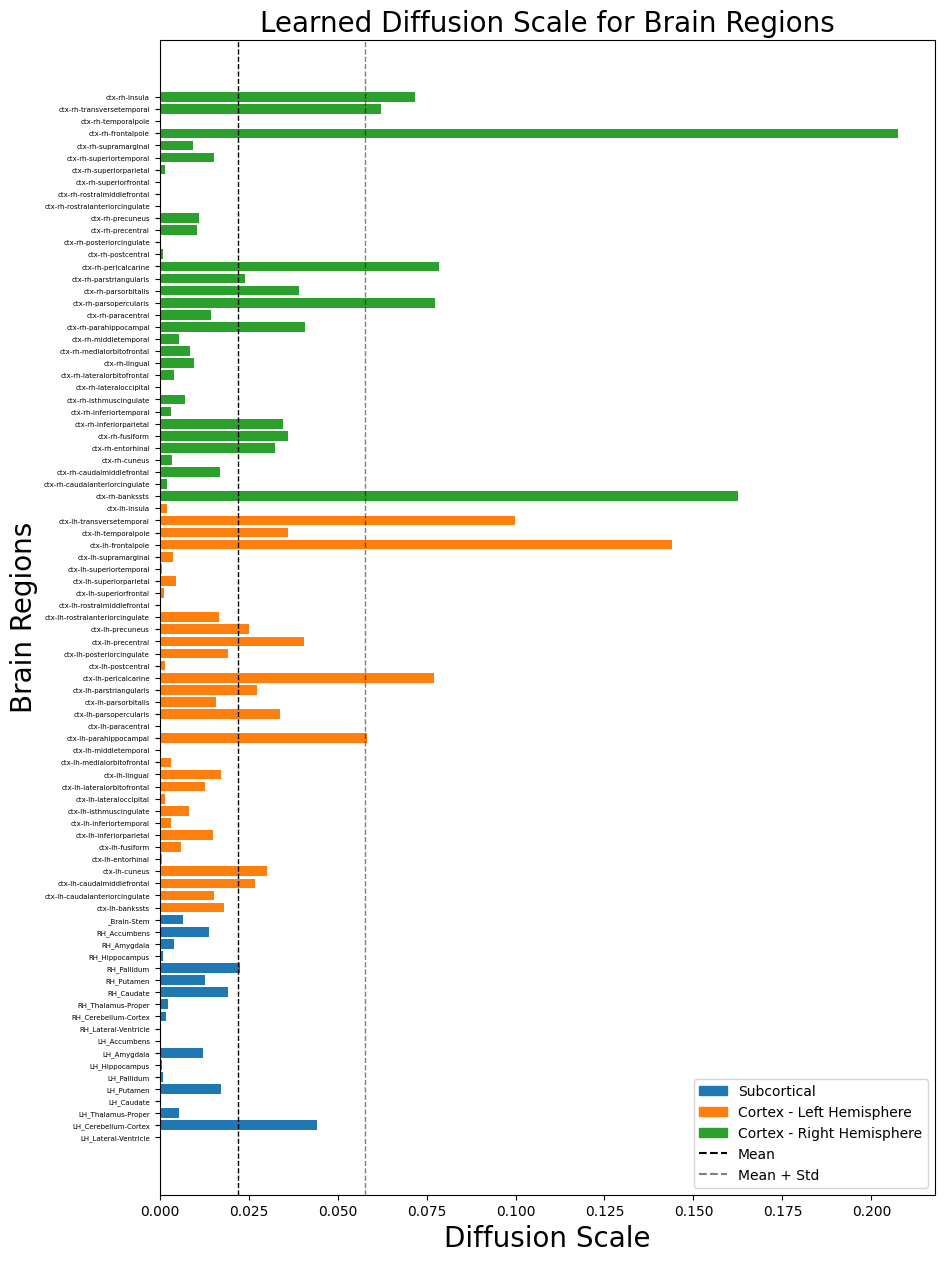

In [40]:
#plot diff_arr_avg and highlight the indices in all_loc
plt.figure(figsize=(10,15))
# plt.subplot(211)
colors =  ['#1f77b4'] * 19 + ['#ff7f0e'] * 34 + ['#2ca02c'] * 34
# colors =  ['#2ca02c'] * 19 +['#1f77b4'] * 34 + ['#ff7f0e'] * 34 
plt.barh(np.arange(len(diff_arr_avg)),diff_arr_avg,color=colors)
# plt.scatter(all_loc,diff_arr_avg[all_loc],c='r')
#also show the index number
# for i in all_loc:
#     plt.text(i,diff_arr_avg[i],brain_lbl[i],rotation=90,fontdict={'size':20})
plt.yticks(np.arange(87),brain_lbl_ls,fontsize=5)
plt.title('Learned Diffusion Scale for Brain Regions',fontsize=20)
plt.ylabel('Brain Regions',fontsize=20)
plt.xlabel('Diffusion Scale',fontsize=20)
#draw dotted lines for mean and std
plt.axvline(np.mean(diff_arr_avg), color='k', linestyle='dashed', linewidth=1,label='Mean')
plt.axvline(np.mean(diff_arr_avg)+np.std(diff_arr_avg), color='k', linestyle='dashed', linewidth=1,label='Mean + Std',alpha=0.5)

blue_patch = mpatches.Patch(color='#1f77b4', label='Subcortical')
green_patch = mpatches.Patch(color='#ff7f0e', label='Cortex - Left Hemisphere')
red_patch = mpatches.Patch(color='#2ca02c', label='Cortex - Right Hemisphere')
from matplotlib import lines as mlines
mean_dash = mlines.Line2D([], [], color='black', linestyle='dashed',label='Mean')
std_dash = mlines.Line2D([], [], color='black', linestyle='dashed',label='Mean + Std',alpha=0.5)
#legend for colors and mean and std
plt.legend(handles=[blue_patch,green_patch,red_patch,mean_dash,std_dash],loc='lower right')
plt.savefig('../figure/avg10scale_concat.pdf', edgecolor='black', dpi=50, facecolor='white', transparent=True, bbox_inches='tight')
plt.show()

# print(pear_ls[train_indices].mean(),pear_ls[val_indices].mean(),pear_ls[test_indices].mean())
# print(mse_ls[train_indices].mean(),mse_ls[val_indices].mean(),mse_ls[test_indices].mean())

In [41]:
# # show the names of all brain regions on x axis
# plt.figure(figsize=(10,5))
# plt.plot(diff_arr)
# plt.title('Learned Diffusion Scale for Brain Regions')
# plt.xlabel('Brain Region Index')
# plt.ylabel('Diffusion Scale')
# plt.show()


In [42]:
#top 10 and bottom 10 t in diff_arr_avg
top10 = np.argsort(diff_arr_avg)[-10:]
bottom10 = np.argsort(diff_arr_avg)[:10]
print('Top 10 t values',diff_arr_avg[top10])
print('Bottom 10 t values',diff_arr_avg[bottom10])
#brain regions corresponding to top 10 and bottom 10 t values
brain_lbl_ls = np.array(brain_lbl_ls)
# print(brain_lbl_ls,'\n',top10)
print('Top 10 brain regions',brain_lbl_ls[top10])
print('Bottom 10 brain regions',brain_lbl_ls[bottom10])
#pd dataframe
data = {'Top 10 t values':diff_arr_avg[top10],'Top 10 brain regions':brain_lbl_ls[top10],
        'Bottom 10 t values':diff_arr_avg[bottom10],'Bottom 10 brain regions':brain_lbl_ls[bottom10]}
df = pd.DataFrame(data)
df.to_csv('../results/top_bottom_10_t.csv')
df

Top 10 t values [0.05832558 0.0623326  0.0716192  0.0771786  0.077401   0.0785676
 0.0999308  0.1438306  0.162382   0.207406  ]
Bottom 10 t values [1.00000000e-08 2.18922000e-08 3.12510512e-05 4.81367140e-05
 5.22100000e-05 7.49665354e-05 1.01450000e-04 1.75428000e-04
 1.85330472e-04 2.31858849e-04]
Top 10 brain regions ['ctx-lh-parahippocampal' 'ctx-rh-transversetemporal' 'ctx-rh-insula'
 'ctx-lh-pericalcarine' 'ctx-rh-parsopercularis' 'ctx-rh-pericalcarine'
 'ctx-lh-transversetemporal' 'ctx-lh-frontalpole' 'ctx-rh-bankssts'
 'ctx-rh-frontalpole']
Bottom 10 brain regions ['ctx-rh-posteriorcingulate' 'LH_Caudate' 'ctx-rh-rostralmiddlefrontal'
 'RH_Lateral-Ventricle' 'LH_Accumbens' 'ctx-rh-temporalpole'
 'ctx-rh-rostralanteriorcingulate' 'ctx-lh-paracentral'
 'ctx-lh-rostralmiddlefrontal' 'ctx-rh-lateraloccipital']


,Top 10 t values,Top 10 brain regions,Bottom 10 t values,Bottom 10 brain regions
0,0.058326,ctx-lh-parahippocampal,1.000000e-08,ctx-rh-posteriorcingulate
1,0.062333,ctx-rh-transversetemporal,2.189220e-08,LH_Caudate
2,0.071619,ctx-rh-insula,3.125105e-05,ctx-rh-rostralmiddlefrontal
3,0.077179,ctx-lh-pericalcarine,4.813671e-05,RH_Lateral-Ventricle
4,0.077401,ctx-rh-parsopercularis,5.221000e-05,LH_Accumbens
5,0.078568,ctx-rh-pericalcarine,7.496654e-05,ctx-rh-temporalpole
6,0.099931,ctx-lh-transversetemporal,1.014500e-04,ctx-rh-rostralanteriorcingulate
7,0.143831,ctx-lh-frontalpole,1.754280e-04,ctx-lh-paracentral
8,0.162382,ctx-rh-bankssts,1.853305e-04,ctx-lh-rostralmiddlefrontal
9,0.207406,ctx-rh-frontalpole,2.318588e-04,ctx-rh-lateraloccipital


## Visualize FC

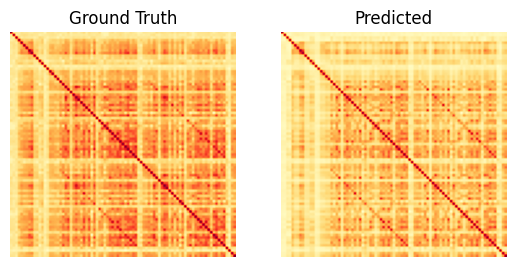

In [43]:
import random
model.eval()
torch.inference_mode()
torch.no_grad()
#randomly select 4 subjects and plot the predicted FC matrix and the ground truth FC matrix
random.seed()
randomlist = random.sample(range(0, 1051), 1)
ind=235
for i in randomlist:
    plt.subplot(121)
    plt.imshow(FC[ind],cmap='YlOrRd')
    plt.axis('off')
    plt.title('Ground Truth')
    plt.subplot(122)
    plt.imshow(model(conn_mat_list[ind].to(device)).squeeze(0).cpu().detach().numpy(),cmap='YlOrRd')
    plt.title('Predicted')
    plt.axis('off')
plt.savefig('../figure/FC_vis.pdf',dpi=300,edgecolor='black',facecolor='white',transparent=True,bbox_inches='tight')